<a href="https://colab.research.google.com/github/NishithaThimmappa/Coursera_projects/blob/main/FaceRecognition_FaceNet_MTCNN_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Aim:** develop a face detection system using FaceNet and an SVM classifier to identify people from photographs

FaceNet Model
FaceNet is a face recognition system that was described by Florian Schroff, et al. at Google in their 2015 paper titled [“FaceNet: A Unified Embedding for Face Recognition and Clustering.”](https://arxiv.org/abs/1503.03832)

We will use the pre-trained Keras [FaceNet model provided by Hiroki Taniai](https://github.com/nyoki-mtl/keras-facenet) in this tutorial. It was trained on [MS-Celeb-1M dataset](https://www.microsoft.com/en-us/research/project/ms-celeb-1m-challenge-recognizing-one-million-celebrities-real-world/) and expects input images to be color, to have their pixel values whitened (standardized across all three channels), and to have a square shape of 160×160 pixels.



In [69]:
from keras.models import load_model

In [70]:
model=load_model('/content/facenet_keras.h5')

In [71]:
print(model.inputs)
print(model.outputs)

[<KerasTensor: shape=(None, 160, 160, 3) dtype=float32 (created by layer 'input_1')>]
[<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'Bottleneck_BatchNorm')>]


We will also use the **Multi-Task Cascaded Convolutional Neural Network**, or MTCNN, for face detection, e.g. finding and extracting faces from photos. This is a state-of-the-art deep learning model for face detection, described in the 2016 paper titled [“Joint Face Detection and Alignment Using Multitask Cascaded Convolutional Networks.”](https://)

In [72]:
pip install mtcnn

In [73]:
import mtcnn
print(mtcnn.__version__)

0.1.0


In [74]:
from PIL import Image
import numpy as np
from mtcnn.mtcnn import MTCNN

In [75]:
! unzip '/content/archive (2).zip'

Archive:  /content/archive (2).zip
replace data/train/ben_afflek/httpcsvkmeuaeccjpg.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: data/train/ben_afflek/httpcsvkmeuaeccjpg.jpg  
  inflating: data/train/ben_afflek/httpimagesfandangocomrImageRendererredesignstaticimgnoxportraitjpgpcpcpcimagesmasterrepositoryperformerimagespjpg.jpg  
  inflating: data/train/ben_afflek/httpssmediacacheakpinimgcomxdbbdbbbececacdecdcdfjpg.jpg  
  inflating: data/train/ben_afflek/httpssmediacacheakpinimgcomxdfdfadcfeabjpg.jpg  
  inflating: data/train/ben_afflek/httpssmediacacheakpinimgcomxedaedabcbefbcbabbjpg.jpg  
  inflating: data/train/ben_afflek/httpssmediacacheakpinimgcomxeebdfdbaaajpg.jpg  
  inflating: data/train/ben_afflek/httpssmediacacheakpinimgcomxeeedcacddeccccacfjpg.jpg  
  inflating: data/train/ben_afflek/httpsuploadwikimediaorgwikipediacommonsthumbddBenAffleckbyGageSkidmorejpgpxBenAffleckbyGageSkidmorejpg.jpg  
  inflating: data/train/ben_afflek/httptrwebimgacstanetcxbdddmediasnmedi

In [76]:
import os

In [77]:
def extract_face(filename, required_size=(160,160)):
  image=Image.open(filename)
  image=image.convert('RGB')
  pixels=np.asarray(image)
  detector=MTCNN()
  results=detector.detect_faces(pixels)
  x1, y1, width, height=results[0]['box']
  x1=abs(x1)
  y1=abs(y1)
  x2, y2=x1+width, y1+height
  face=pixels[y1:y2, x1:x2]
  image=Image.fromarray(face)
  image=image.resize(required_size)
  face_array=np.asarray(image)
  return face_array


In [78]:
def load_faces(directory):
  faces=list()
  for filename in os.listdir(directory):
    path=directory+filename
    face=extract_face(path)
    faces.append(face)
  return faces

def load_dataset(directory):
  x,y=list(), list()
  for subdir in os.listdir(directory):
    path=directory+subdir+'/'
    if not os.path.isdir(path):
      continue
    faces=load_faces(path)
    labels=[subdir for _ in range(len(faces))]
    print('>loaded %d examples for class : %s'% (len(faces), subdir))
    x.extend(faces)
    y.extend(labels)
  return np.asarray(x), np.asarray(y)


In [79]:
trainX, trainY=load_dataset('/content/data/train/')

>loaded 22 examples for class : mindy_kaling
>loaded 14 examples for class : ben_afflek
>loaded 21 examples for class : jerry_seinfeld
>loaded 17 examples for class : elton_john
>loaded 19 examples for class : madonna


In [80]:
print(trainX.shape, trainY.shape)

(93, 160, 160, 3) (93,)


In [81]:
testX, testY=load_dataset('/content/data/val/')

>loaded 5 examples for class : mindy_kaling
>loaded 5 examples for class : ben_afflek
>loaded 5 examples for class : jerry_seinfeld
>loaded 5 examples for class : elton_john
>loaded 5 examples for class : madonna


In [82]:
np.savez_compressed('5-celebrity-faces-dataset.npz', trainX, trainY, testX, testY)

**Face Embedding using FaceNet**

In [83]:
data=np.load('5-celebrity-faces-dataset.npz')

In [84]:
trainX, trainY, testX, testY=data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']

In [85]:
print('loaded', trainX.shape, trainY.shape, testX.shape, testY.shape)

loaded (93, 160, 160, 3) (93,) (25, 160, 160, 3) (25,)


In [86]:
import tensorflow as tf

In [87]:
model=tf.keras.models.load_model('/content/facenet_keras.h5')

In [88]:
print(model)

In [89]:
model.summary()

Model: "inception_resnet_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv2d_1a_3x3 (Conv2D)         (None, 79, 79, 32)   864         ['input_1[0][0]']                
                                                                                                  
 Conv2d_1a_3x3_BatchNorm (Batch  (None, 79, 79, 32)  96          ['Conv2d_1a_3x3[0][0]']          
 Normalization)                                                                                   
                                                                                

In [90]:
tf.keras.utils.plot_model(model)

tcmalloc: large alloc 1177313280 bytes == 0x55e2342f8000 @  0x7f15247a9001 0x7f1520a401fa 0x7f1520a402ad 0x7f1521bcb6df 0x7f15220c2261 0x7f152453f468 0x7f1524541d53 0x55e2326cc092 0x7f1523ef4bf7 0x55e2326cc12a



In [91]:
def get_embedding(model, face_pixels):
  face_pixels=face_pixels.astype('float32')
  mean, std=face_pixels.mean(), face_pixels.std()
  face_pixels=(face_pixels-mean)/std
  samples=np.expand_dims(face_pixels, axis=0)
  yhat=model.predict(samples)
  return yhat[0]

In [92]:
newTrainX=list()
for face_pixels in trainX:
  embedding=get_embedding(model, face_pixels)
  newTrainX.append(embedding)
newTrainX=np.asarray(newTrainX)
print(newTrainX.shape)


(93, 128)


In [93]:
newTestX=list()
for face_pixels in testX:
  embedding=get_embedding(model,face_pixels)
  newTestX.append(embedding)
newTestX=np.asarray(newTestX)
print(newTestX.shape)

(25, 128)


In [94]:
np.savez_compressed('5-celebrity-faces-embeddings.npz',newTrainX, trainY, newTestX, testY)

Face Classification

In [112]:
data=np.load('5-celebrity-faces-embeddings.npz')

In [113]:
trainX, trainY, testX, testY=data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']

In [114]:
print('Dataset: train=%d, test=%d'%(trainX.shape[0], testX.shape[0]))

Dataset: train=93, test=25


In [115]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import Normalizer, LabelEncoder
from sklearn.svm import SVC

In [116]:
in_encoder=Normalizer(norm='l2')
trainX=in_encoder.transform(trainX)
testX=in_encoder.transform(testX)

out_encoder=LabelEncoder()
out_encoder.fit(trainY)
trainY=out_encoder.transform(trainY)
testY=out_encoder.transform(testY)

model=SVC(kernel='linear', probability=True)
model.fit(trainX, trainY)

yhat_train=model.predict(trainX)
yhat_test=model.predict(testX)

score_train=accuracy_score(trainY, yhat_train)
score_test=accuracy_score(testY, yhat_test)

print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Accuracy: train=100.000, test=100.000


Predicted: elton_john (89.586)
Expected: elton_john


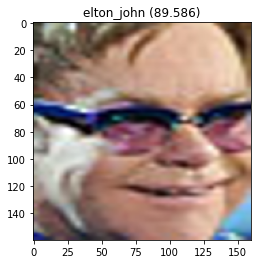

In [122]:
from random import choice
import matplotlib.pyplot as plt

selection=choice([i for i in range(testX.shape[0])])
data = np.load('5-celebrity-faces-dataset.npz')
test_faces=data['arr_2']
face_pixels_choice=test_faces[selection]
face_emb_choice=testX[selection]
face_class_choice=testY[selection]
face_name_choice=out_encoder.inverse_transform([face_class_choice])

samples=np.expand_dims(face_emb_choice, axis=0)
ythat_class=model.predict(samples)
ythat_prob=model.predict_proba(samples)

class_index=ythat_class[0]
class_probability=ythat_prob[0, class_index]*100
predict_names=out_encoder.inverse_transform(ythat_class)

print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Expected: %s' % face_name_choice[0])

plt.imshow(face_pixels_choice)
title = '%s (%.3f)' % (predict_names[0], class_probability)
plt.title(title)
plt.show()
